# Google Colabの設定

In [1]:
# setting for Google Colab
!git clone https://github.com/hayamatomoe/WeaveSynthesizer.git
import os
path = '/content/WeaveSynthesizer'
os.chdir(path)
!ls
from google.colab import drive
drive.mount('/content/drive')
%mkdir img

Cloning into 'WeaveSynthesizer'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 26 (delta 5), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (26/26), done.
README.md  sample.ipynb  torchweave  tutorial_J1.ipynb
Mounted at /content/drive


# ライブラリの読み込み

In [1]:
# import libraries
import torchweave.structures as tws
import torchweave.functions as twf
import importlib
import functools
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

# 緯糸(weft)，経糸(warp)の本数設定

- `multWeave`: 多重織りの層数．今のところ３で固定．
- `thrLen`: 綜絖(threading)に通す経糸の本数．織機に応じて設定．
- `trdLen`: 踏み木(treadling)の踏み方．越の数．
- `tuLen`: タイアップのサイズ．自由に設定．値が小さいほど模様が粗い．
- `asp`: 画像表示するときのアスペクト比．太さの比を経糸:緯糸=3.8:1に設定している．


In [2]:
multWeave = 3
# thrLen = 2000//multWeave # warp 9024px=150cm
thrLen = 9024//multWeave # warp 9024px=150cm
# n2:9024
# n4:5120
# n6:4608
trdLen = 512 # weft 1152px=70cm, 500cm=8228, 800cm=12665
# trdLen = 12665 # weft 1152px=70cm, 500cm=8228, 800cm=12665
tuLen = 512
asp=trdLen*3.8/(thrLen*multWeave)

# 多重織りの基底になる波形と濃度マップ
各基底(三重織の場合は3つ)それぞれに綜絖，踏み木の波形を生成．`torchWeave`ライブラリ`Wav`クラスのオブジェクトを生成．

## base 1, base 2, base 3 の波形($1\leq i\leq 3$)
- `func1a, func2a, func3a`: 踏み木の波形$f_{i,a}(x)$
- `func1b, func2b, func3b`: 綜絖の波形$f_{i,b}(x)$

`.plot`で踏み木・綜絖それぞれの波形を描画．後でこの２つの波形から行列をつくって積をとる．

## 濃度マップ
パラメータ`a`をとり，`.density`でfloat配列`b1, b2, b3`をつくってplotすれば，2つの波形から平面グラデーションができる．これは２変数関数$f_i(x,y)=|f_{i,b}(x)-\mod(af_{i,a}(y),1)|$の濃度マップである．二色の緯糸を使ってこのグラデーションをつくる．

## base 1

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


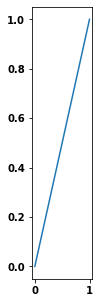

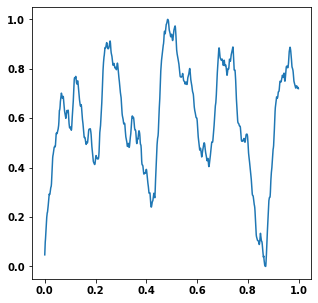

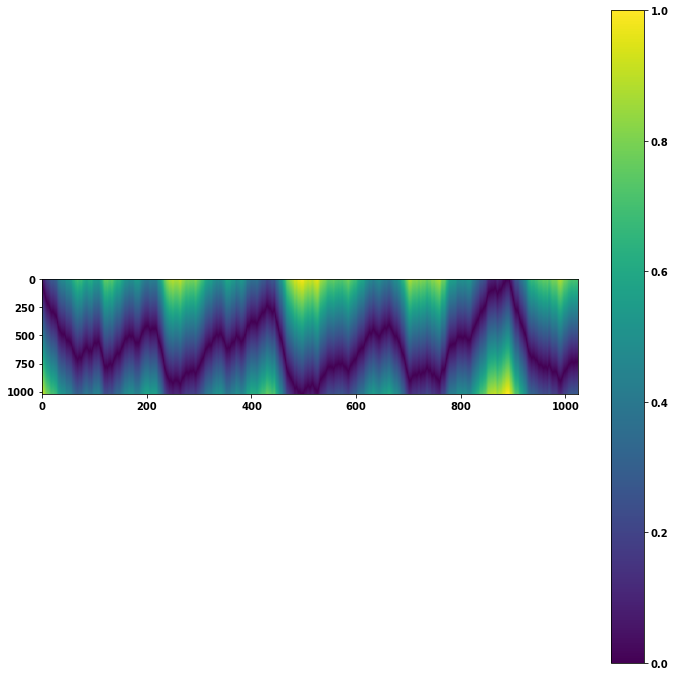

In [3]:

def func1a(x):
    return x

wav1a=tws.Wav(func1a)   
wav1a.plot(aspect=asp)

def func1b(x):
    freq =6
    func=functools.partial(twf.fbm, H=1., freq=freq, phase=74, itr=7, func=twf.vnoise_)
    n = twf.warp(x, func=func, wt=.1/freq, itr=2)
    s = twf.fbm(x, H=1., freq=freq*1.5, phase=0, itr=6, func=twf.sin_)
    return torch.lerp(n, s, 0.3)

wav1b=tws.Wav(func1b)   
wav1b.plot()

b1 = tws.density(wav1a,wav1b, a=1)
tws.densityplot(b1, aspect=asp, bar = True)


## base 2

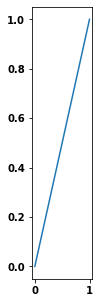

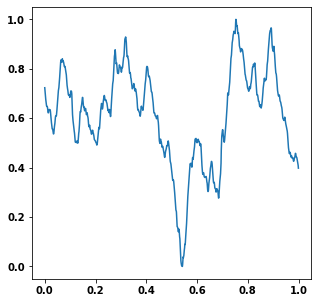

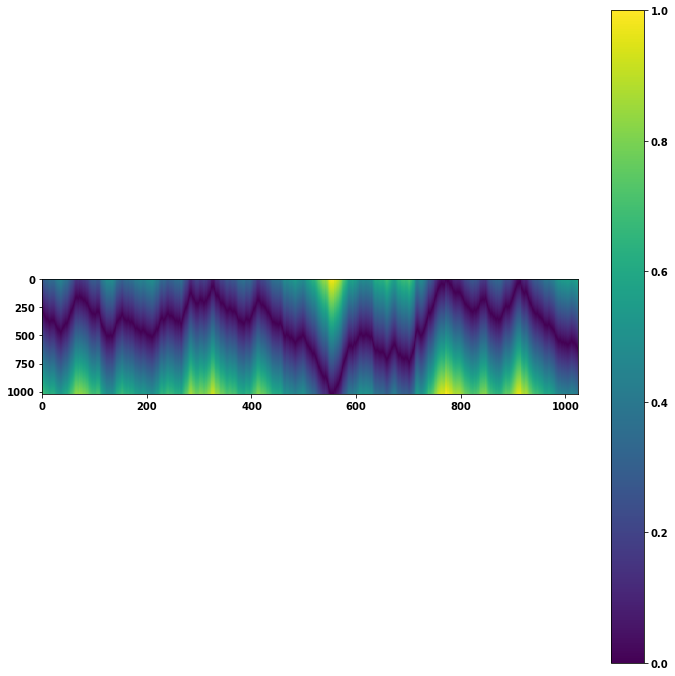

In [4]:
def func2a(x):
    return x
wav2a=tws.Wav(func2a)   
wav2a.plot(aspect=asp)

def func2b_(x,freq):  
    func=functools.partial(twf.fbm, H=1., freq=freq, phase=1345, itr=8, func=twf.vnoise_)
    n = twf.warp(x, func=func, wt=.1/freq, itr=3)
    s = twf.fbm(x, H=1., freq=12., phase=0.45, itr=6, func=twf.sin_)
    return torch.lerp(n, s, 0.2)
def func2b(x):
    return func2b_(x, 6)
wav2b=tws.Wav(func2b)   
wav2b.plot()

b2 = tws.density(wav2a,wav2b, a=-1)
tws.densityplot(b2, aspect=asp, bar = True)

## base 3

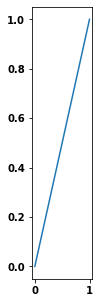

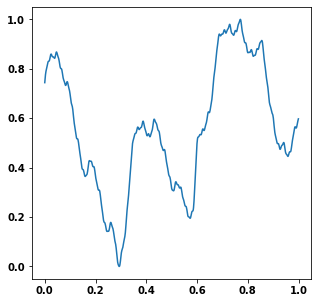

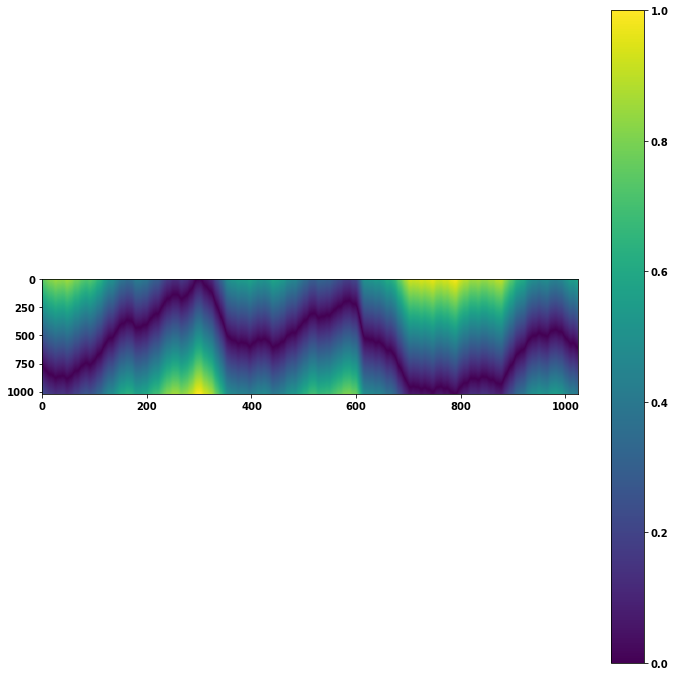

In [5]:
def func3a(x):
    return x

wav3a=tws.Wav(func3a)   
wav3a.plot(aspect=asp)

def func3b_(x,freq):  
    func=functools.partial(twf.fbm, H=1., freq=freq, phase=636, itr=4, func=twf.vnoise_)
    n = twf.warp(x, func=func, wt=.1/freq, itr=2)
    s = twf.fbm(x, H=1., freq=freq*1.5, phase=0, itr=6, func=twf.sin_)
    return torch.lerp(n, s, 0.25)
def func3b(x):
    return func3b_(x, 4)

wav3b=tws.Wav(func3b)   
wav3b.plot()

b3 = tws.density(wav3a,wav3b, a=1)
tws.densityplot(b3, aspect=asp, bar = True)

# 多重織りの層の重なり方
基底の濃度マップを閾値`lev1, lev2, lev3`で切って，二値化した配列`b1_bin, b2_bin, b3_bin`をつくる．

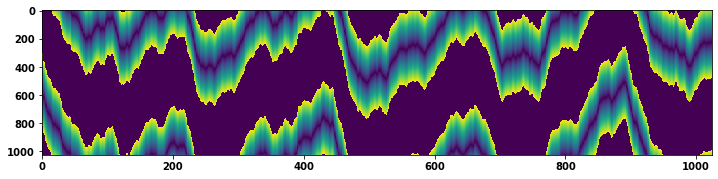

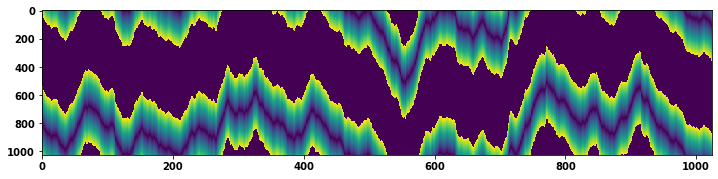

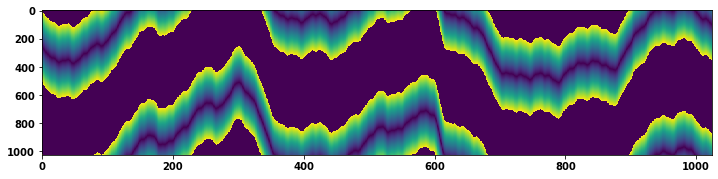

In [6]:
lev1=[0.25,0.75]
b1_bin = tws.density(wav1a,wav1b, a=1, levels=lev1)
tws.densityplot(b1_bin*torch.abs(b1-0.5), aspect=asp)

lev2=[0.25,0.75]
b2_bin = tws.density(wav2a,wav2b, a=-1, levels=lev2)
tws.densityplot(b2_bin*torch.abs(b2-0.5), aspect=asp)

lev3=[0.25,0.75]
b3_bin = tws.density(wav3a,wav3b, a=1, levels=lev3)
tws.densityplot(b3_bin*torch.abs(b3-0.5), aspect=asp)

## 重なり方の順序関係
3つのバイナリ値の組み合わせ($2^3=8$通り)から順序関係($3!=6$通り)を決める．

In [7]:
for bin1 in range(2):
    for bin2 in range(2):
        for bin3 in range(2):
            bin3_ = int(bin3+bin2-bin1 > 0)
            print([bin1,bin2,bin3])
            print('lay1', ['*', bin1, bin2], bin1+bin2)
            print('lay2', [int(not bin1), '*', bin3_], int(not bin1) + bin3_)
            print('lay3', [int(not bin2), int(not bin3_), '*'], int(not bin2) + int(not bin3_))

[0, 0, 0]
lay1 ['*', 0, 0] 0
lay2 [1, '*', 0] 1
lay3 [1, 1, '*'] 2
[0, 0, 1]
lay1 ['*', 0, 0] 0
lay2 [1, '*', 1] 2
lay3 [1, 0, '*'] 1
[0, 1, 0]
lay1 ['*', 0, 1] 1
lay2 [1, '*', 1] 2
lay3 [0, 0, '*'] 0
[0, 1, 1]
lay1 ['*', 0, 1] 1
lay2 [1, '*', 1] 2
lay3 [0, 0, '*'] 0
[1, 0, 0]
lay1 ['*', 1, 0] 1
lay2 [0, '*', 0] 0
lay3 [1, 1, '*'] 2
[1, 0, 1]
lay1 ['*', 1, 0] 1
lay2 [0, '*', 0] 0
lay3 [1, 1, '*'] 2
[1, 1, 0]
lay1 ['*', 1, 1] 2
lay2 [0, '*', 0] 0
lay3 [0, 1, '*'] 1
[1, 1, 1]
lay1 ['*', 1, 1] 2
lay2 [0, '*', 1] 1
lay3 [0, 0, '*'] 0


## 緯糸の色
杼番と色．各レイヤーごとに2色の緯糸でグラデーション．

In [8]:
#RGB color
#layer1
weft1 = [0,0,0] #black
weft2 = [1,0,0] #red
#layer2
weft3 = [0,1,0] #green
weft4 = [0,0,1] #blue
#layer3
weft5 = [1,1,0] #yellow
weft6 = [1,0,1] #red-purple

## 多重織りシミュレーション
`b1_bin, b2_bin, b3_bin`からビット演算で3つのレイヤーをつくり，それぞれに`b1, b1, b2`の組織をかける．

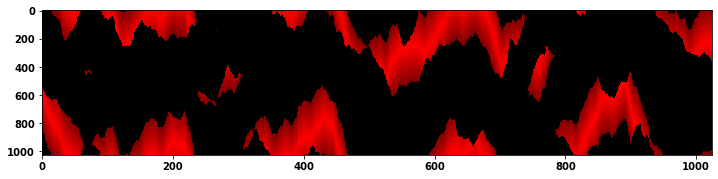

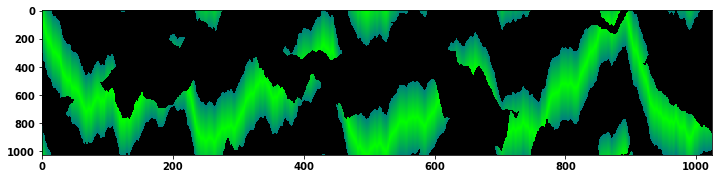

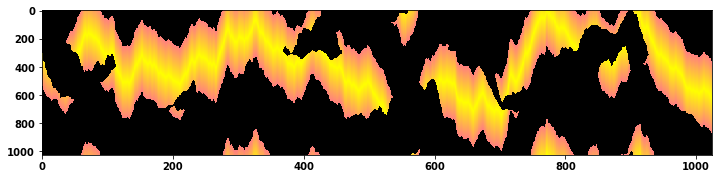

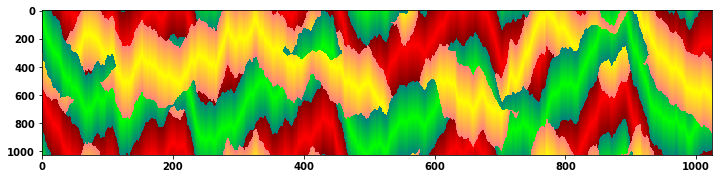

In [9]:
b3_ = (b3_bin + b2_bin - b1_bin) > 0

lay1 = torch.logical_and(b1_bin, b2_bin)
lay2 = torch.logical_and(torch.logical_not(b1_bin), b3_) 
lay3 = torch.logical_and(torch.logical_not(b2_bin), torch.logical_not(b3_))

#simulation of each layer
lay1_=torch.unsqueeze(lay1.float(),dim=2)*tws.colorize(torch.abs(2*(b1-0.5)),[torch.Tensor(weft2),torch.Tensor(weft1)])
tws.densityplot(lay1_, aspect=asp)

lay2_=torch.unsqueeze(lay2.float(),dim=2)*tws.colorize(torch.abs(2*(b1-0.5)),[torch.Tensor(weft4),torch.Tensor(weft3)])
tws.densityplot(lay2_, aspect=asp)

lay3_=torch.unsqueeze(lay3.float(),dim=2)*tws.colorize(torch.abs(2*(b2-0.5)),[torch.Tensor(weft6),torch.Tensor(weft5)])
tws.densityplot(lay3_, aspect=asp)

#sum
tws.densityplot(lay1_+lay2_+lay3_,aspect=asp)


# 綜絖(thread), 踏み木(treadling)の行列生成
綜絖と踏み木の行列は，波形から綾織りをもとにつくる．綾の本数`line`によって，波形の滑らかさが変わる．`line`が少ないほど綾織りに近い．

- `thr, trd`は`Tensor`クラスのオブジェクト
    - `thr`のサイズは`(tuLen,thrLen)`
    - `trd`のサイズは`(tuLen,trdLen)`
    - `.plot`で描画，オプション`save=True`で保存．`name=''`でファイル名追加．

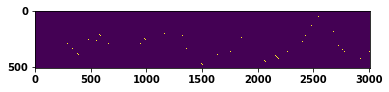

<Figure size 1440x1440 with 0 Axes>

21-0325-1109-33850888_lay1_thr_


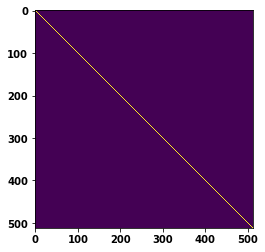

<Figure size 1440x1440 with 0 Axes>

21-0325-1109-34102215_lay1_trd_


In [10]:
importlib.reload(tws)
line=32
thr1=wav1b.sparse(wd=thrLen, ht=tuLen, n=line)
trd1=wav1a.sparse(wd=trdLen, ht=tuLen, n=line)
thr2=wav2b.sparse(wd=thrLen, ht=tuLen, n=line)
trd2=wav2a.sparse(wd=trdLen, ht=tuLen, n=line)
thr3=wav3b.sparse(wd=thrLen, ht=tuLen, n=line)
trd3=wav3a.sparse(wd=trdLen, ht=tuLen, n=line)

thr1.plot(save=True, name='lay1_thr')
trd1.plot(save=True, name='lay1_trd')

# タイアップの行列生成
タイアップは正方行列からなる．これは次のようにつくる．

1. 数列を生成
1. 数列からバイナリ数列を生成
1. 生成したバイナリ数列をずらしながら正方行列をつくる

このプログラムではタイアップにぼかし織りをつくる．

## 数列生成のための関数

In [11]:
importlib.reload(tws)
def shade(n, step=1):
    a = torch.arange(1,1+n//2, step)
    a_ = n-a
    a_ = a_.flip(0)
    b = torch.cat([a, a_], 0).reshape(1,-1)
    c = torch.cat([sym(b),sym(b.flip(1))], 0).reshape(1,-1)
    return c
def sym(s):
    c = torch.cat([s,s.flip(1)],0)
    c = c.transpose(0,1).flatten()
    return c
def reverse(s):
    zero = torch.tensor([[0]])
    return torch.cat([zero, s], dim=1)

## ぼかし織り数列
$a=[1,n-1,2,n-2,...,\lfloor n/2\rfloor, \lceil n/2\rceil]$
$b=[n-1,1,n-2,2,..., \lceil n/2\rceil,\lfloor n/2\rfloor]$

`shade(n)`: a<>flip(a)<>b<>flip(b)

nが偶数のとき，すべての和は$n\times n\times 2$


In [12]:
seq=shade(4)
print(seq)
print(torch.sum(seq))
print(reverse(seq))

tensor([[1, 3, 2, 2, 2, 2, 3, 1, 3, 1, 2, 2, 2, 2, 1, 3]])
tensor(32)
tensor([[0, 1, 3, 2, 2, 2, 2, 3, 1, 3, 1, 2, 2, 2, 2, 1, 3]])


`seq`クラスオブジェクトの数列からバイナリ数列をつくる．
- `[2,2,2]`->`[1,1,0,0,1,1]`
- `[0,2,1,3]`->`[0,0,1,0,0,0]`

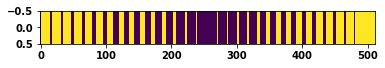

<Figure size 1440x1440 with 0 Axes>

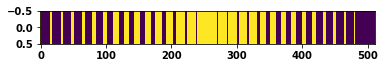

<Figure size 1440x1440 with 0 Axes>

In [13]:
importlib.reload(tws)
tuSeq1_ = shade(16)
tuSeq1r_ = reverse(tuSeq1_)
tuSeq1 = tws.Seq(tuSeq1_)
tuSeq1r = tws.Seq(tuSeq1r_)
tuSeq1.plot(wd=tuLen)
tuSeq1r.plot(wd=tuLen)

## 色シミュレーションの設定

In [14]:
# color simulation
w1tensor = torch.tensor(weft1, dtype=torch.uint8).reshape(1,1,1,3)*255
w2tensor = torch.tensor(weft2, dtype=torch.uint8).reshape(1,1,1,3)*255
w3tensor = torch.tensor(weft3, dtype=torch.uint8).reshape(1,1,1,3)*255
w4tensor = torch.tensor(weft4, dtype=torch.uint8).reshape(1,1,1,3)*255
w5tensor = torch.tensor(weft5, dtype=torch.uint8).reshape(1,1,1,3)*255
w6tensor = torch.tensor(weft6, dtype=torch.uint8).reshape(1,1,1,3)*255

color1 = torch.cat([w1tensor,w2tensor], 0).cuda()
color1_back = torch.flip(color1,(0,))

color2 = torch.cat([w3tensor,w4tensor], 0).cuda() 
color2_back = torch.flip(color2,(0,))

color3 = torch.cat([w5tensor,w6tensor], 0).cuda()
color3_back = torch.flip(color3,(0,))

# ぼかし織りテンソル生成

多重織りの各レイヤーごとにぼかし織り数列(表・裏)をずらしてテンソルをつくる．

- 各レイヤーごとに，上でつくったぼかし織り数列(表・裏)をくっつけてテンソルをつくる
- テンソルを`.roll`でずらして，テンソルの階数を増やす
    - パラメータの配列はずらし方の数列．綾織りの綾の角度．
        - `[1]`なら１つずつ右にずれる
        - `[-1,2]`なら1つずつ「左にずれる」「2つずつ右にずれる」を交互に繰り返す
    - オプション変数`diff`で，さらに配列`[n,m]`の分だけずらす．
        - i行目を`i*n%m`だけずらす
- `tu1, tu2, tu3`は`Tensor`クラスのオブジェクト
    - サイズは`(2,tuLen,tuLen)`
    


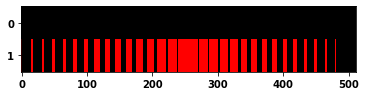

<Figure size 1440x1440 with 0 Axes>

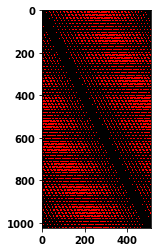

<Figure size 1440x1440 with 0 Axes>

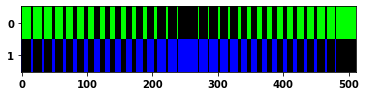

<Figure size 1440x1440 with 0 Axes>

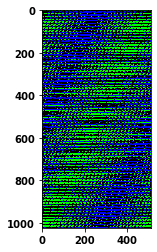

<Figure size 1440x1440 with 0 Axes>

21-0325-1109-35747811_color_5_


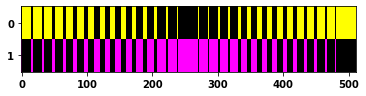

<Figure size 1440x1440 with 0 Axes>

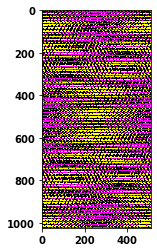

<Figure size 1440x1440 with 0 Axes>

In [15]:
n=5
tu_sat = [0,11]
tu_sat_ = [n,11]
s = tuSeq1.copy()
s.append(tuSeq1r)
s.plot(color=color1, wd=tuLen)
tu1 = s.roll([1], diff = tu_sat, wd=tuLen)
tu1.plot(color=color1)

s = tuSeq1.copy()
s.append(tuSeq1r)
s.plot(color=color2, wd=tuLen)
tu2 = s.roll([-1,-1,-1,-2], diff = tu_sat_, wd=tuLen)
tu2.plot(color=color2, save=True, name=str(n))

s = tuSeq1.copy()
s.append(tuSeq1r)
s.plot(color=color3, wd=tuLen)
tu3 = s.roll([1,1,-1,-1], diff = tu_sat, wd=tuLen)
tu3.plot(color=color3)

# テンソル演算
上でつくった綜絖，踏み木，タイアップのテンソルをかける．

## 計算例
次のようなテンソルに対して，

$A=\begin{pmatrix}1&0&1\\0&1&0\end{pmatrix},\quad 
B=\left(\begin{pmatrix}1&0\\1&1\end{pmatrix}, \begin{pmatrix}0&1\\0&0\end{pmatrix}\right)=\left(B_1,B_2\right),\quad 
C=\begin{pmatrix}1&1&0\\0&0&1\end{pmatrix}$

次のように計算する．

$\mathrm{mul}(A,B,C)=\left({}^tA.B_1.C, {}^tA.B_2.C\right)=
\left(
    \begin{pmatrix}1&1&0\\1&1&1\\1&1&0\end{pmatrix},
    \begin{pmatrix}0&0&1\\0&0&0\\0&0&1\end{pmatrix}
\right)
$



A


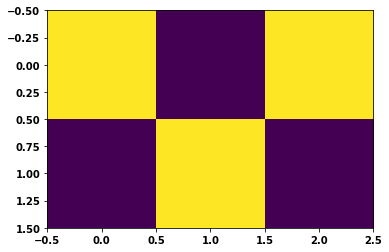

<Figure size 1440x1440 with 0 Axes>

B


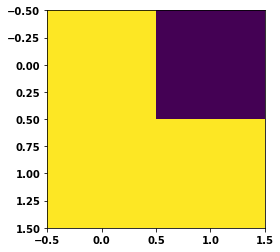

<Figure size 1440x1440 with 0 Axes>

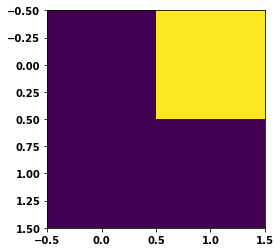

<Figure size 1440x1440 with 0 Axes>

C


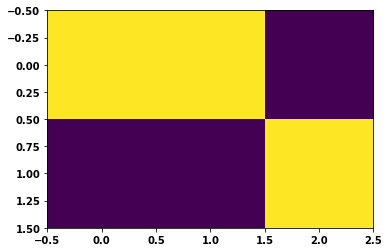

<Figure size 1440x1440 with 0 Axes>

mul(A,B,C)


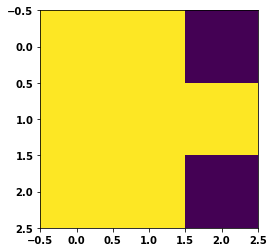

<Figure size 1440x1440 with 0 Axes>

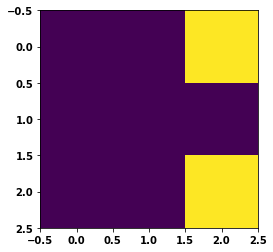

<Figure size 1440x1440 with 0 Axes>

In [34]:
A = tws.Tensor(
    [
        [1,0,1],
        [0,1,0]
    ]
)
print('A')
A.plot()
B = tws.Tensor(
    [
        [
            [1,0],
            [1,1]
        ],
        [
            [0,1],
            [0,0]
        ],
    ]
)
print('B')
B.plot()
C = tws.Tensor(
    [
        [1,1,0],
        [0,0,1]
    ]
)
print('C')
C.plot()
print('mul(A,B,C)')
P = tws.matmul(A,B,C)
P.plot()


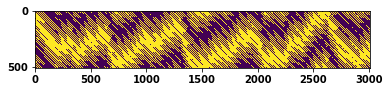

<Figure size 1440x1440 with 0 Axes>

21-0325-1134-03581170_lay1_


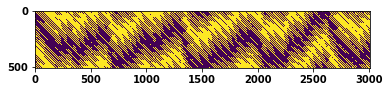

<Figure size 1440x1440 with 0 Axes>

21-0325-1134-03581170_lay1_


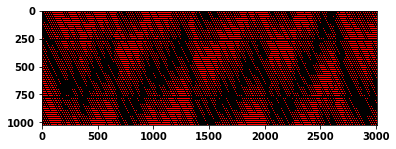

<Figure size 1440x1440 with 0 Axes>

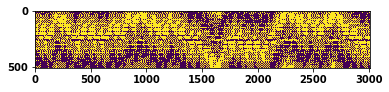

<Figure size 1440x1440 with 0 Axes>

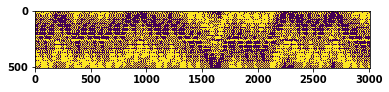

<Figure size 1440x1440 with 0 Axes>

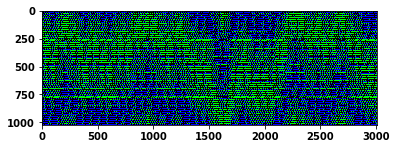

<Figure size 1440x1440 with 0 Axes>

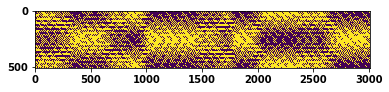

<Figure size 1440x1440 with 0 Axes>

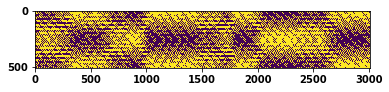

<Figure size 1440x1440 with 0 Axes>

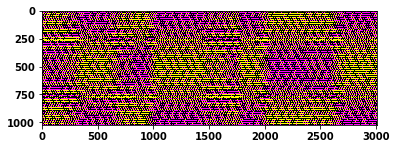

<Figure size 1440x1440 with 0 Axes>

In [38]:
importlib.reload(tws)
pat1 = tws.matmul(trd1, tu1, thr1)
pat1.plot(save=True, name='lay1') #binary
pat1.plot(color=color1) #color simulation

pat2 = tws.matmul(trd2, tu2, thr2)
pat2.plot()
pat2.plot(color=color2)

pat3 = tws.matmul(trd3, tu3, thr3)
pat3.plot()
pat3.plot(color=color3)

# Satin Mask

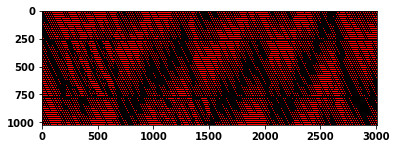

<Figure size 1440x1440 with 0 Axes>

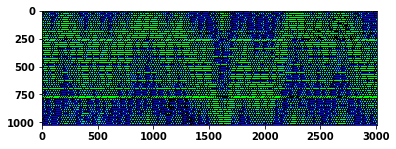

<Figure size 1440x1440 with 0 Axes>

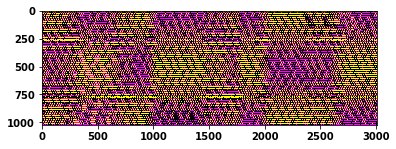

<Figure size 1440x1440 with 0 Axes>

In [17]:
importlib.reload(tws)
sat1 = pat1.satin(17,1,13)
# sat1 = pat1.satin(6,1,4)
# sat1.plot(save=True)
mask1 = pat1.mask(sat1)
mask1 = tws.Tensor(mask1)
mask1.plot(color=color1)
mask2 = pat2.mask(sat1)
mask2 = tws.Tensor(mask2)
mask2.plot(color=color2)
mask3 = pat3.mask(sat1)
mask3 = tws.Tensor(mask3)
mask3.plot(color=color3)
del pat1, pat2, pat3

# Basis for multiweave

## sequence

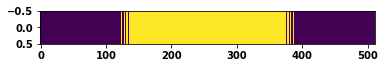

<Figure size 1440x1440 with 0 Axes>

In [18]:
def shade1(n, step=1):
    a = torch.arange(1,1+n//2, step)
    a_ = n-a
    a_ = a_.flip(0)
    b = torch.cat([a, a_], 0).reshape(1,-1)
    return sym(b)
def tone(n, wd=512, levels=[0.25,0.75], step=1):
    wd = wd - 2*n**2
    w0 = torch.tensor([wd * levels[0]]).long()
    w2 = torch.tensor([wd * levels[1]]).long()
    w1 = w2-w0
    w2 = wd-w2
    s = shade1(n, step=step)
    w = torch.cat([w0,s,w1,s,w2], 0)
    return w
tone(10,step=1)
test = tws.Seq(tone(4))
test.plot()
del test


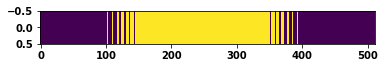

<Figure size 1440x1440 with 0 Axes>

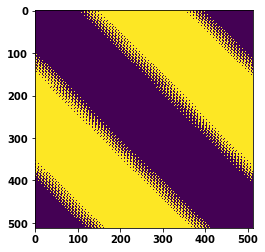

<Figure size 1440x1440 with 0 Axes>

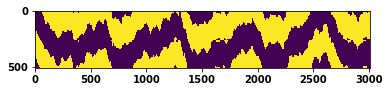

<Figure size 1440x1440 with 0 Axes>

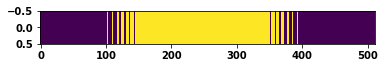

<Figure size 1440x1440 with 0 Axes>

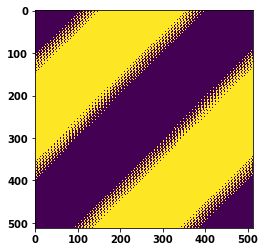

<Figure size 1440x1440 with 0 Axes>

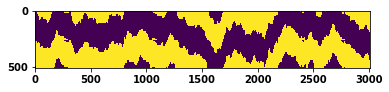

<Figure size 1440x1440 with 0 Axes>

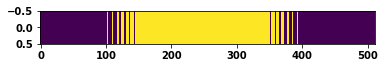

<Figure size 1440x1440 with 0 Axes>

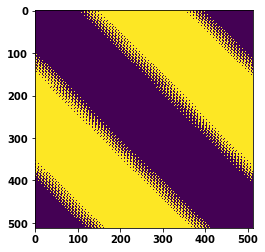

<Figure size 1440x1440 with 0 Axes>

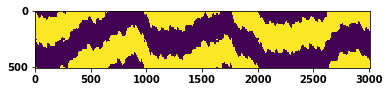

<Figure size 1440x1440 with 0 Axes>

In [19]:
importlib.reload(tws)
# baseSeq1 = seq1(128,64)
# baseSeq1 = baseSeq1.roll(8,dims=1)
# baseSeq1 = dotSeq(baseSeq1, itr=2, lng=20)
baseSeq1 = tws.Seq(tone(7, levels=lev1))
baseSeq1.plot()
base1 = baseSeq1.roll([1], diff = [3,7],wd=tuLen)
base1.plot(wd=tuLen)
base1 = tws.matmul(trd1, base1, thr1)
for i in range(4):
    base1 = tws.Tensor(base1.unisolate(low=4, high=4))
base1 = tws.Tensor(base1.unisolate(low=1,high=1,nbd=1))
base1.plot()

baseSeq2 = tws.Seq(tone(7, levels=lev2))
baseSeq2.plot()
base2 = baseSeq2.roll([-1], diff = [4,7],init=0, wd=tuLen)
base2.plot(wd=tuLen)
base2 = tws.matmul(trd2, base2, thr2)
for i in range(4):
    base2 = tws.Tensor(base2.unisolate(low=4, high=4))
base2 = tws.Tensor(base2.unisolate(low=1,high=1,nbd=1))
base2.plot()

baseSeq3 = tws.Seq(tone(7, levels=lev3))
baseSeq3.plot()
base3 = baseSeq3.roll([1], diff = [3,7],init=0, wd=tuLen)
base3.plot(wd=tuLen)
base3 = tws.matmul(trd3, base3, thr3)
for i in range(4):
    base3 = tws.Tensor(base3.unisolate(low=4, high=4))
base3 = tws.Tensor(base3.unisolate(low=1,high=1,nbd=1))
base3.plot()

# Triple weave

## base

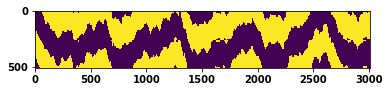

<Figure size 1440x1440 with 0 Axes>

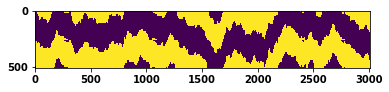

<Figure size 1440x1440 with 0 Axes>

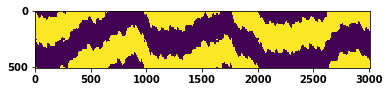

<Figure size 1440x1440 with 0 Axes>

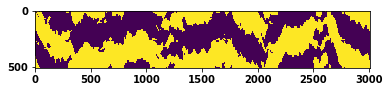

<Figure size 1440x1440 with 0 Axes>

In [20]:
importlib.reload(tws)
from torchweave.structures import b_xor, b_and, b_or, b_not, clamp, mult, minus, plus

base_1 = base1.copy()
base_1.plot()

base_not_1 = b_not(base_1)

base_2 = base2.copy()
base_2.plot()

base_not_2 = b_not(base_2)

base_3 = base3.copy()
base_3.plot()
base_3 = tws.Tensor(torch.clamp(base_3.tensor.short() + base_2.tensor.short() - base_1.tensor.short(), 0, 1))
base_3.plot()
base_not_3 = b_not(base_3)
# base_not_3.plot()

del base1, base2, base3


## 三重織りシミュレーション

### 表

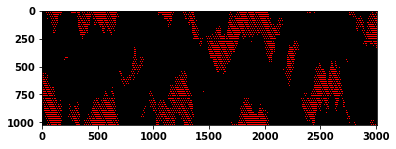

<Figure size 1440x1440 with 0 Axes>

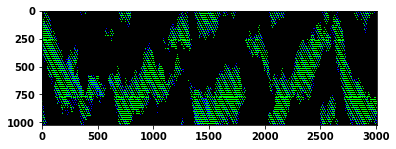

<Figure size 1440x1440 with 0 Axes>

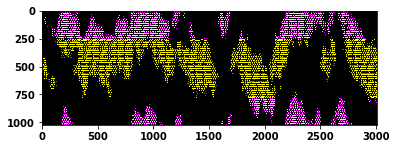

<Figure size 1440x1440 with 0 Axes>

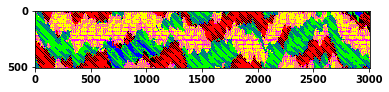

<Figure size 1440x1440 with 0 Axes>

In [21]:
b1 = torch.logical_and(base_1.tensor, base_2.tensor)
b1 = torch.cat([b1,b1],0)
b1 = b1 * mask1.tensor
# b1 = torch.cat([b1,b1,b1], 2)
b2 = torch.logical_and(torch.logical_not(base_1.tensor), base_3.tensor)
b2 = torch.cat([b2,b2],0)
b2 = b2 * mask1.tensor
# b2 = torch.cat([b2,b2,b2], 2)
b3 = torch.logical_and(torch.logical_not(base_2.tensor), torch.logical_not(base_3.tensor))
b3 = torch.cat([b3,b3],0)
b3 = b3 * mask2.tensor
# b3 = torch.cat([b3,b3,b3], 2)

mask1_ = tws.Tensor(b1)
mask2_ = tws.Tensor(b2)
mask3_ = tws.Tensor(b3)
mask1_.plot(color=color1)
mask2_.plot(color=color2)
mask3_.plot(color=color3)
mask_ = mask1_.copy()
mask_.append(mask2_)
mask_.append(mask3_)

color7 = torch.cat([color1,color2,color3], 0).cuda()
# color6 = torch.cat([r,g,b,rg,gb,rb], 0).cuda()
mask_.plot(color=color7, sum=True)

del mask_, mask1_, mask2_, mask3_

### 表(銀糸/箔＋綿)

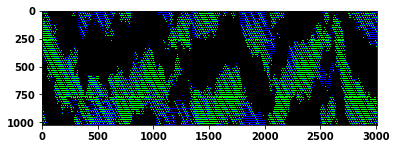

<Figure size 1440x1440 with 0 Axes>

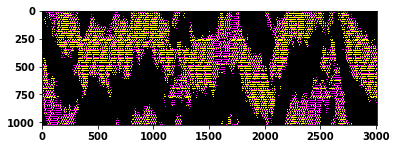

<Figure size 1440x1440 with 0 Axes>

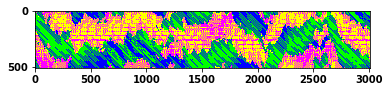

<Figure size 1440x1440 with 0 Axes>

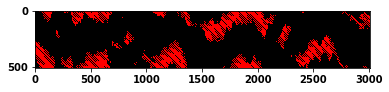

<Figure size 1440x1440 with 0 Axes>

In [22]:
importlib.reload(tws)
b1 = torch.logical_and(base_1.tensor, base_2.tensor)

b2 = torch.logical_and(torch.logical_not(base_1.tensor), base_3.tensor)
b2 = torch.logical_or(b2, torch.logical_and(b1, base_3.tensor))
b2 = torch.cat([b2,b2],0)
b2 = b2 * mask1.tensor

b3 = torch.logical_and(torch.logical_not(base_2.tensor), torch.logical_not(base_3.tensor))
b3 = torch.logical_or(b3, torch.logical_and(b1, torch.logical_not(base_3.tensor)))
b3 = torch.cat([b3,b3],0)
b3 = b3 * mask2.tensor

b1 = torch.cat([b1,b1],0)
b1 = b1 * mask1.tensor

mask1_ = tws.Tensor(b1)
mask2_ = tws.Tensor(b2)
mask3_ = tws.Tensor(b3)
mask2_.plot(color=color2)
mask3_.plot(color=color3)
mask_ = mask2_.copy()
mask_.append(mask3_)
gray = torch.tensor([200,200,200], dtype=torch.uint8).reshape(1,1,1,3)
white = torch.tensor([255,255,255], dtype=torch.uint8).reshape(1,1,1,3)
color8 = torch.cat([color2,color3], 0).cuda()
# color6 = torch.cat([r,g,b,rg,gb,rb], 0).cuda()
mask_.plot(color=color8, sum=True, name='front_haku_men')
mask1_.plot(color=color1, sum=True)

del mask_, mask2_, mask3_

### 裏

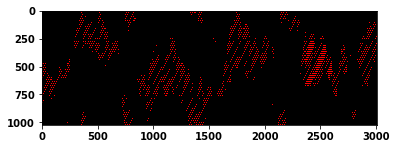

<Figure size 1440x1440 with 0 Axes>

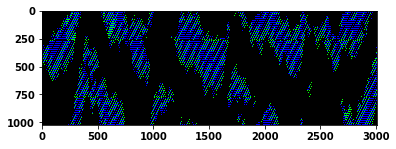

<Figure size 1440x1440 with 0 Axes>

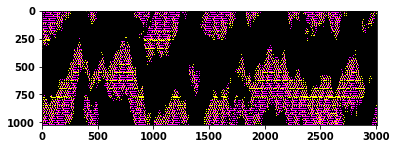

<Figure size 1440x1440 with 0 Axes>

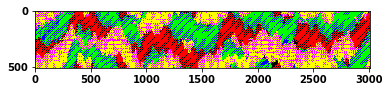

<Figure size 1440x1440 with 0 Axes>

In [23]:
b1 = torch.logical_and(torch.logical_not(base_1.tensor), torch.logical_not(base_2.tensor))
b1 = torch.cat([b1,b1],0)
b1 = b1 * mask1.tensor
b1 = torch.flip(b1,(2,))

b2 = torch.logical_and(base_1.tensor, torch.logical_not(base_3.tensor))
b2 = torch.cat([b2,b2],0)
b2 = b2 * mask1.tensor
b2 = torch.flip(b2, (2,))

b3 = torch.logical_and(base_2.tensor, base_3.tensor)
b3 = torch.cat([b3,b3],0)
b3 = b3 * mask2.tensor
b3 = torch.flip(b3, (2,))

mask1_ = tws.Tensor(b1)
mask2_ = tws.Tensor(b2)
mask3_ = tws.Tensor(b3)
mask1_.plot(color=color1)
mask2_.plot(color=color2)
mask3_.plot(color=color3)
mask_ = mask1_.copy()
mask_.append(mask2_)
mask_.append(mask3_)
# color7 = torch.cat([color1,color2,color3], 0).cuda()
# color6 = torch.cat([r,g,b,rg,gb,rb], 0).cuda()

color7_back = torch.cat([color1_back,color2_back,color3_back], 0).cuda()
mask_.plot(color=color7_back, sum=True, name='back')
del mask_, mask1_, mask2_, mask3_

### 裏(銀糸/箔＋綿)

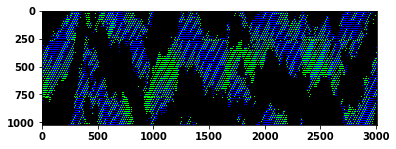

<Figure size 1440x1440 with 0 Axes>

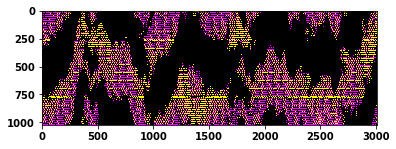

<Figure size 1440x1440 with 0 Axes>

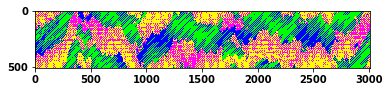

<Figure size 1440x1440 with 0 Axes>

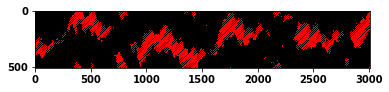

<Figure size 1440x1440 with 0 Axes>

In [24]:
b1 = torch.logical_and(torch.logical_not(base_1.tensor), torch.logical_not(base_2.tensor))


b2 = torch.logical_and(base_1.tensor, torch.logical_not(base_3.tensor))
b2 = torch.logical_or(b2, torch.logical_and(b1, torch.logical_not(base_3.tensor)))
b2 = torch.cat([b2,b2],0)
b2 = b2 * mask1.tensor
b2 = torch.flip(b2, (2,))

b3 = torch.logical_and(base_2.tensor, base_3.tensor)
b3 = torch.logical_or(b3, torch.logical_and(b1, base_3.tensor))
b3 = torch.cat([b3,b3],0)
b3 = b3 * mask2.tensor
b3 = torch.flip(b3, (2,))


b1 = torch.cat([b1,b1],0)
b1 = b1 * mask1.tensor
b1 = torch.flip(b1,(2,))

mask1_ = tws.Tensor(b1)
mask2_ = tws.Tensor(b2)
mask3_ = tws.Tensor(b3)
mask2_.plot(color=color2)
mask3_.plot(color=color3)
mask_ = mask2_.copy()
mask_.append(mask3_)
gray = torch.tensor([200,200,200], dtype=torch.uint8).reshape(1,1,1,3)
white = torch.tensor([255,255,255], dtype=torch.uint8).reshape(1,1,1,3)
color8_back = torch.cat([color2_back,color3_back], 0).cuda()
# color6 = torch.cat([r,g,b,rg,gb,rb], 0).cuda()
mask_.plot(color=color8_back, sum=True, name='back_haku_men')
mask1_.plot(color=color1_back, sum=True, name='back_ginshi')

del mask_, mask1_, mask2_, mask3_

## 多重織り，層ごとの出力

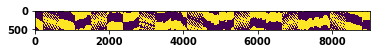

<Figure size 1440x1440 with 0 Axes>

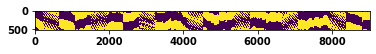

<Figure size 1440x1440 with 0 Axes>

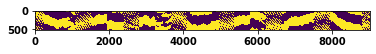

<Figure size 1440x1440 with 0 Axes>

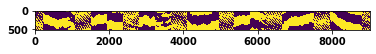

<Figure size 1440x1440 with 0 Axes>

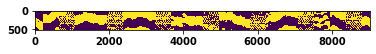

<Figure size 1440x1440 with 0 Axes>

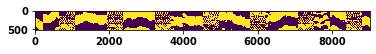

<Figure size 1440x1440 with 0 Axes>

In [25]:
importlib.reload(tws)
def triple(t, lay):
    lay_ = []
    for i in t.tensor:
        i = torch.unsqueeze(i, 0)
        i = tws.Tensor(i)#[]
        if lay == 0:
            t_ = [i, base_1, base_2]#[*,1,0]
        elif lay == 1:
            t_ = [base_not_1, i, base_3]#0,*,0
        elif lay == 2:
            t_ = [base_not_2, base_not_3, i]#1,1,*
        t__ = tws.catTensor(t_)
        t__ = t__.wdJoint(n=3)
        lay_.append(t__)
    return tws.catTensor(lay_)
tri_lay1 = triple(mask1, 0)
tri_lay1.plot(name='ginshi')
tri_lay2 = triple(mask1, 1)
tri_lay2.plot(name='haku')
tri_lay3 = triple(mask2, 2)
tri_lay3.plot(name='men')

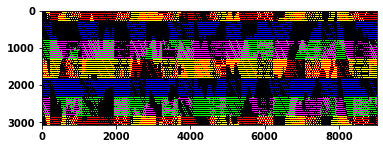

<Figure size 1440x1440 with 0 Axes>

In [26]:
# importlib.reload(tws)
# r = torch.tensor([255,0,0], dtype=torch.uint8).reshape(1,1,1,3)
# rg = torch.tensor([255,255,0], dtype=torch.uint8).reshape(1,1,1,3)
# g = torch.tensor([0,255,0], dtype=torch.uint8).reshape(1,1,1,3)
# b = torch.tensor([0,0,255], dtype=torch.uint8).reshape(1,1,1,3)
# gb = torch.tensor([0,255,255], dtype=torch.uint8).reshape(1,1,1,3)
# rb = torch.tensor([255,0,255], dtype=torch.uint8).reshape(1,1,1,3)
# color6 = torch.cat([r,g,b,rg,gb,rb], 0).cuda()

tri = tri_lay1.copy()
tri.append(tri_lay2)
tri.append(tri_lay3)
tri.plot(color=color7, name='all')
del tri